In [1]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Set memory growth to True to allocate memory as needed
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set a memory limit of 10GB (10240MB)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    except RuntimeError as e:
        print(e)


In [2]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Number of GPUs available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)

    # Perform a simple computation on the GPU
    with tf.device('/GPU:0'):
        a = tf.constant(2.0)
        b = tf.constant(3.0)
        c = a * b
        print(f"Result of computation on GPU: {c.numpy()}")
else:
    print("No GPU found")


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result of computation on GPU: 6.0


# Get the data

In [3]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

# Import necessary libraries and modules

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [5]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Model 2_a : Mobvnet2 SGD

# Prepare the data

In [7]:
batch_size = 32
img_height = 224  # Adjusted for MobileNetV2
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model building

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Model training

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint('Model2_a.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.6768 - accuracy: 0.1688
Epoch 1: val_accuracy improved from -inf to 0.20741, saving model to Model2_a.h5
1899/1899 [==============================] - 1008s 529ms/step - loss: 2.6768 - accuracy: 0.1688 - val_loss: 2.4963 - val_accuracy: 0.2074
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.4317 - accuracy: 0.2251
Epoch 2: val_accuracy improved from 0.20741 to 0.25145, saving model to Model2_a.h5
1899/1899 [==============================] - 983s 517ms/step - loss: 2.4317 - accuracy: 0.2251 - val_loss: 2.3356 - val_accuracy: 0.2515
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.3043 - accuracy: 0.2660
Epoch 3: val_accuracy improved from 0.25145 to 0.28929, saving model to Model2_a.h5
1899/1899 [==============================] - 969s 510ms/step - loss: 2.3043 - accuracy: 0.2660 - val_loss: 2.2218 - val_accuracy: 0.2893
Epoch 4/10
1899/1899 [=======================

In [10]:
model.save('2_a.h5')

# Evaluate the model

In [11]:
model.load_weights('Model2_a.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 75s 313ms/step - loss: 1.8675 - accuracy: 0.3863
Test accuracy: 0.3863396644592285


# Plot accuracy and loss graphs

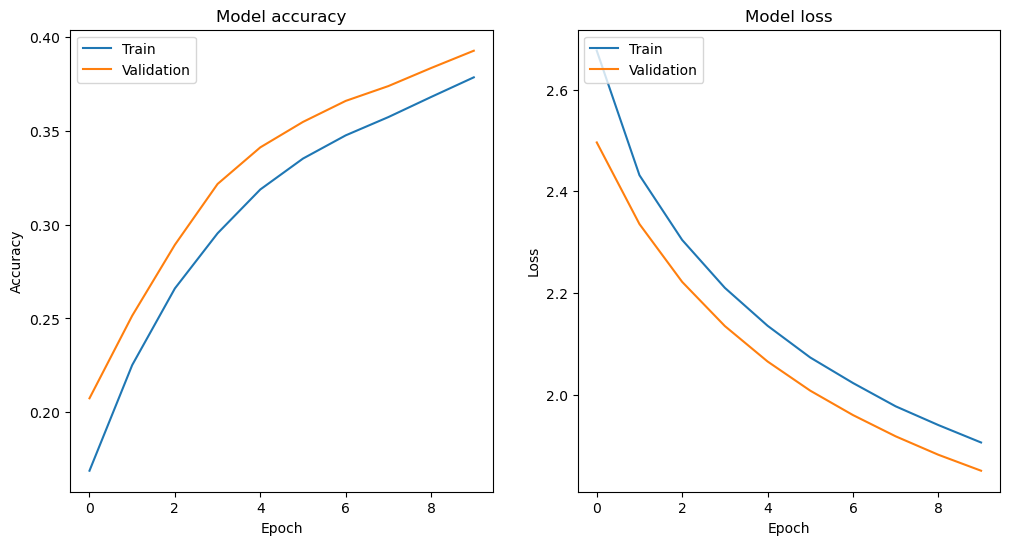

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [3]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Plot confusion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 76s 315ms/step


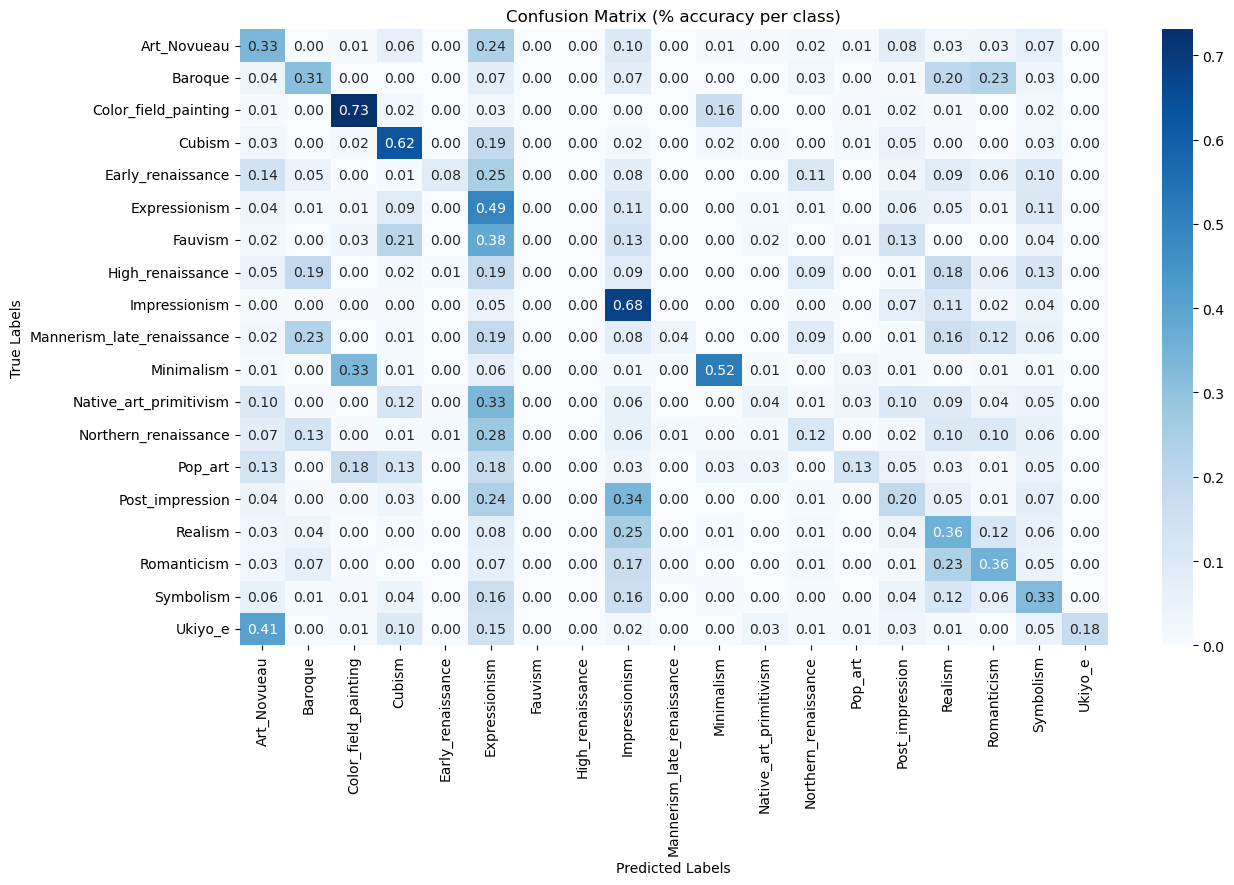

                            precision    recall  f1-score   support

               Art_Novueau       0.31      0.33      0.32       413
                   Baroque       0.39      0.31      0.35       418
      Color_field_painting       0.55      0.73      0.63       182
                    Cubism       0.41      0.62      0.50       261
         Early_renaissance       0.65      0.08      0.15       157
             Expressionism       0.26      0.49      0.34       659
                   Fauvism       0.00      0.00      0.00        89
          High_renaissance       0.00      0.00      0.00       126
             Impressionism       0.50      0.68      0.57      1314
Mannerism_late_renaissance       0.42      0.04      0.07       137
                Minimalism       0.58      0.52      0.54       147
    Native_art_primitivism       0.30      0.04      0.08       278
      Northern_renaissance       0.21      0.12      0.15       240
                   Pop_art       0.44      0.13

C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# Path to saved model
model_path = 'C:\\Users\\PRANAV\\Model2_a.h5'
model = load_model(model_path)


test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 299
image_width = 299

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Model 2_b: Adam, BN, dropout

# Prepare the data

In [14]:
batch_size = 32
img_height = 224  # Adjusted for MobileNetV2
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model Building

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# Model training

In [16]:
# Define callbacks
checkpoint = ModelCheckpoint('Model2_b.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 1.9777 - accuracy: 0.3775
Epoch 1: val_accuracy improved from -inf to 0.46229, saving model to Model2_b.h5
1899/1899 [==============================] - 985s 517ms/step - loss: 1.9777 - accuracy: 0.3775 - val_loss: 1.7049 - val_accuracy: 0.4623
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.5703 - accuracy: 0.4768
Epoch 2: val_accuracy improved from 0.46229 to 0.50435, saving model to Model2_b.h5
1899/1899 [==============================] - 976s 514ms/step - loss: 1.5703 - accuracy: 0.4768 - val_loss: 1.5220 - val_accuracy: 0.5044
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.4083 - accuracy: 0.5236
Epoch 3: val_accuracy improved from 0.50435 to 0.50857, saving model to Model2_b.h5
1899/1899 [==============================] - 998s 525ms/step - loss: 1.4083 - accuracy: 0.5236 - val_loss: 1.4922 - val_accuracy: 0.5086
Epoch 4/10
1899/1899 [========================

In [20]:
model.save('2_b.h5')

# Evaluate the model

In [21]:
model.load_weights('Model2_b.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 72s 301ms/step - loss: 1.3326 - accuracy: 0.5653
Test accuracy: 0.5652689933776855


# Plot accuracy and loss graphs

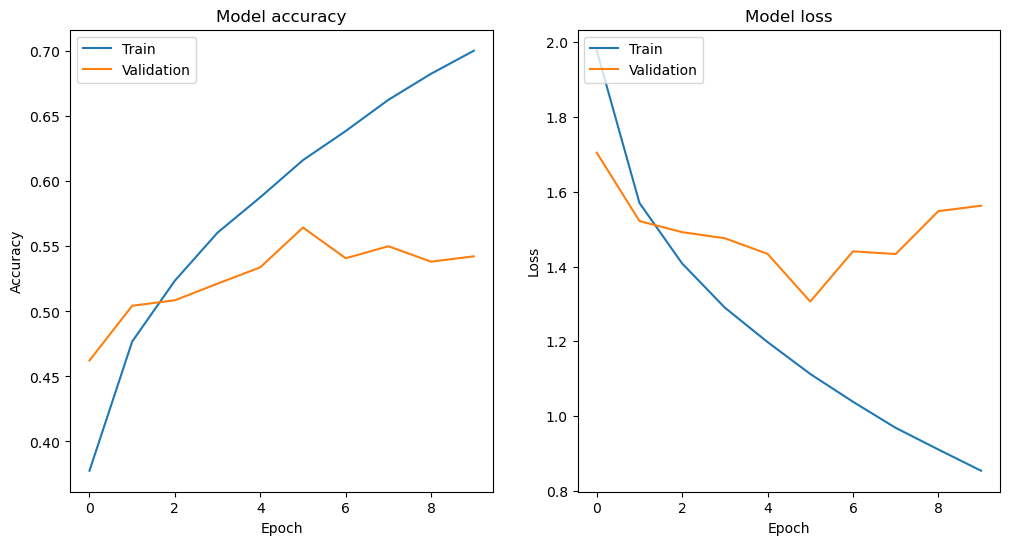

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Plot confusion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 74s 307ms/step


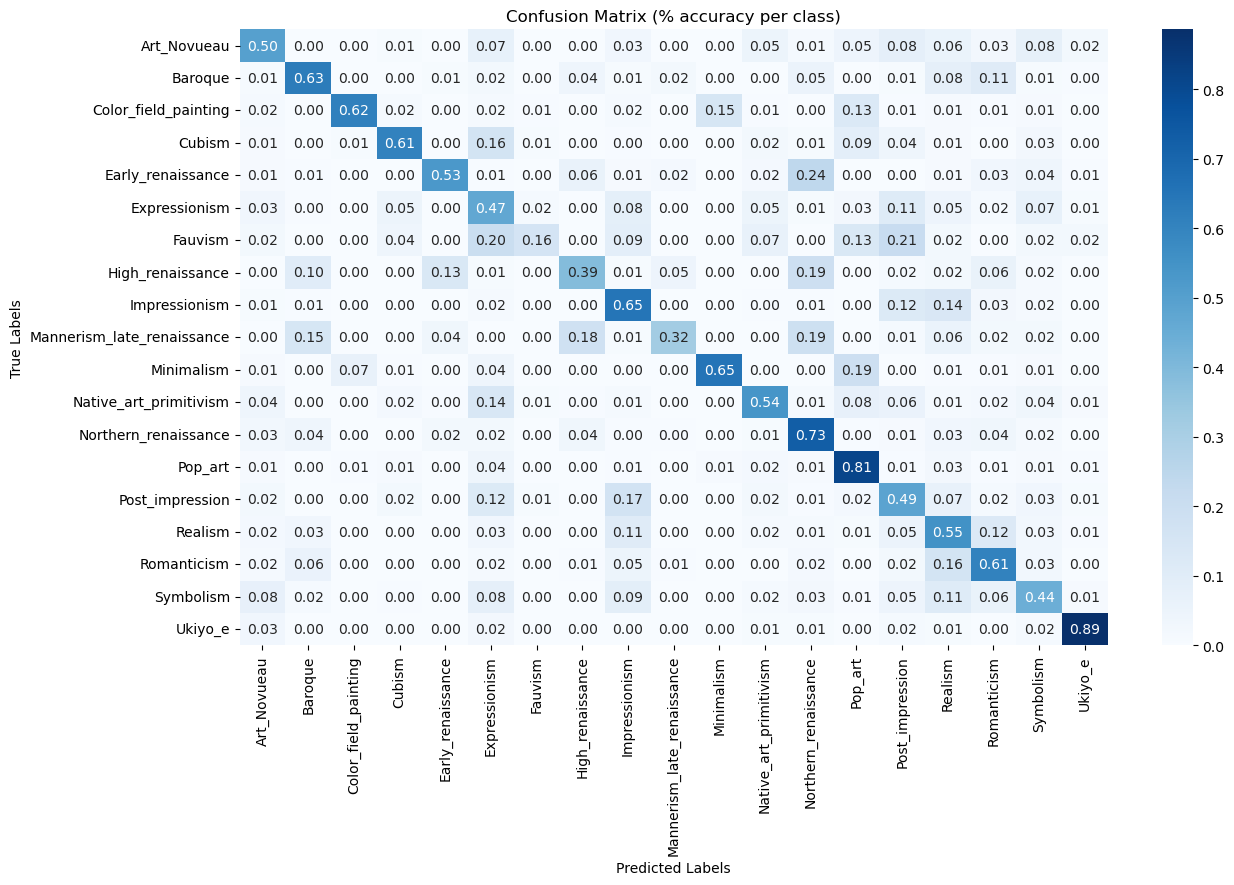

                            precision    recall  f1-score   support

               Art_Novueau       0.58      0.50      0.54       413
                   Baroque       0.65      0.63      0.64       418
      Color_field_painting       0.90      0.62      0.73       182
                    Cubism       0.69      0.61      0.65       261
         Early_renaissance       0.70      0.53      0.60       157
             Expressionism       0.48      0.47      0.47       659
                   Fauvism       0.38      0.16      0.22        89
          High_renaissance       0.41      0.39      0.40       126
             Impressionism       0.68      0.65      0.67      1314
Mannerism_late_renaissance       0.63      0.32      0.43       137
                Minimalism       0.76      0.65      0.70       147
    Native_art_primitivism       0.55      0.54      0.55       278
      Northern_renaissance       0.49      0.73      0.58       240
                   Pop_art       0.41      0.81

In [6]:
# Path to saved model
model_path = 'C:\\Users\\PRANAV\\Model2_b.h5'
model = load_model(model_path)


test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 224
image_width = 224

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Model 2_c:  Batch size 16


# Prepare the data

In [7]:
batch_size = 16
img_height = 224  # Adjusted for MobileNetV2
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model building

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Model training

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint('Model2_c.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
3798/3798 [==============================] - ETA: 0s - loss: 2.0137 - accuracy: 0.3644
Epoch 1: val_accuracy improved from -inf to 0.46624, saving model to Model2_c.h5
3798/3798 [==============================] - 1045s 274ms/step - loss: 2.0137 - accuracy: 0.3644 - val_loss: 1.6249 - val_accuracy: 0.4662
Epoch 2/10
3798/3798 [==============================] - ETA: 0s - loss: 1.6249 - accuracy: 0.4596
Epoch 2: val_accuracy improved from 0.46624 to 0.50725, saving model to Model2_c.h5
3798/3798 [==============================] - 1007s 265ms/step - loss: 1.6249 - accuracy: 0.4596 - val_loss: 1.4586 - val_accuracy: 0.5073
Epoch 3/10
3798/3798 [==============================] - ETA: 0s - loss: 1.4639 - accuracy: 0.5037
Epoch 3: val_accuracy improved from 0.50725 to 0.52123, saving model to Model2_c.h5
3798/3798 [==============================] - 998s 263ms/step - loss: 1.4639 - accuracy: 0.5037 - val_loss: 1.4457 - val_accuracy: 0.5212
Epoch 4/10
3798/3798 [======================

In [13]:
model.save('2_c.h5')

# Evaluate the model

In [10]:
model.load_weights('Model2_c.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


474/474 [==============================] - 74s 156ms/step - loss: 1.4429 - accuracy: 0.5595
Test accuracy: 0.5594673156738281


# Plot accuracy and loss graphs

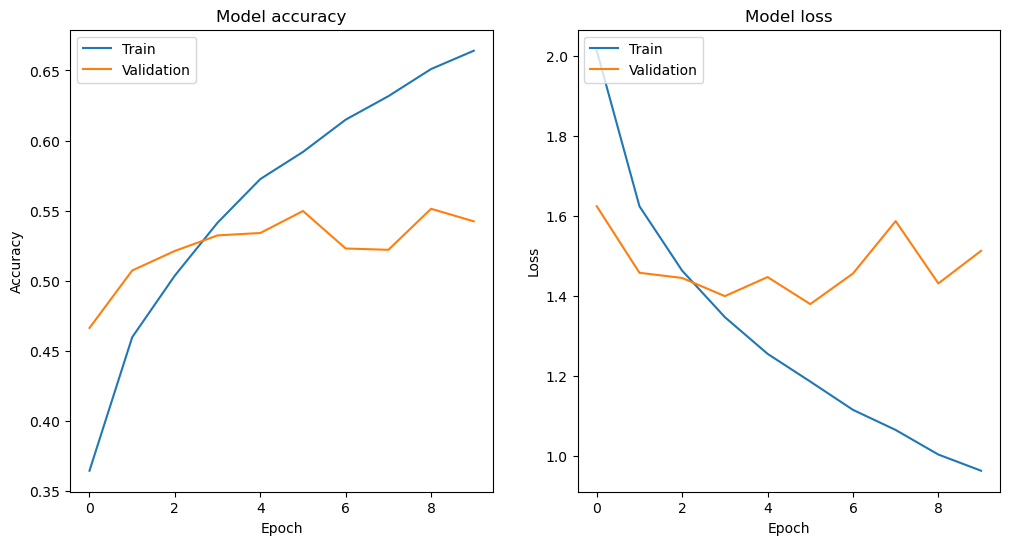

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Plot confusion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 73s 301ms/step


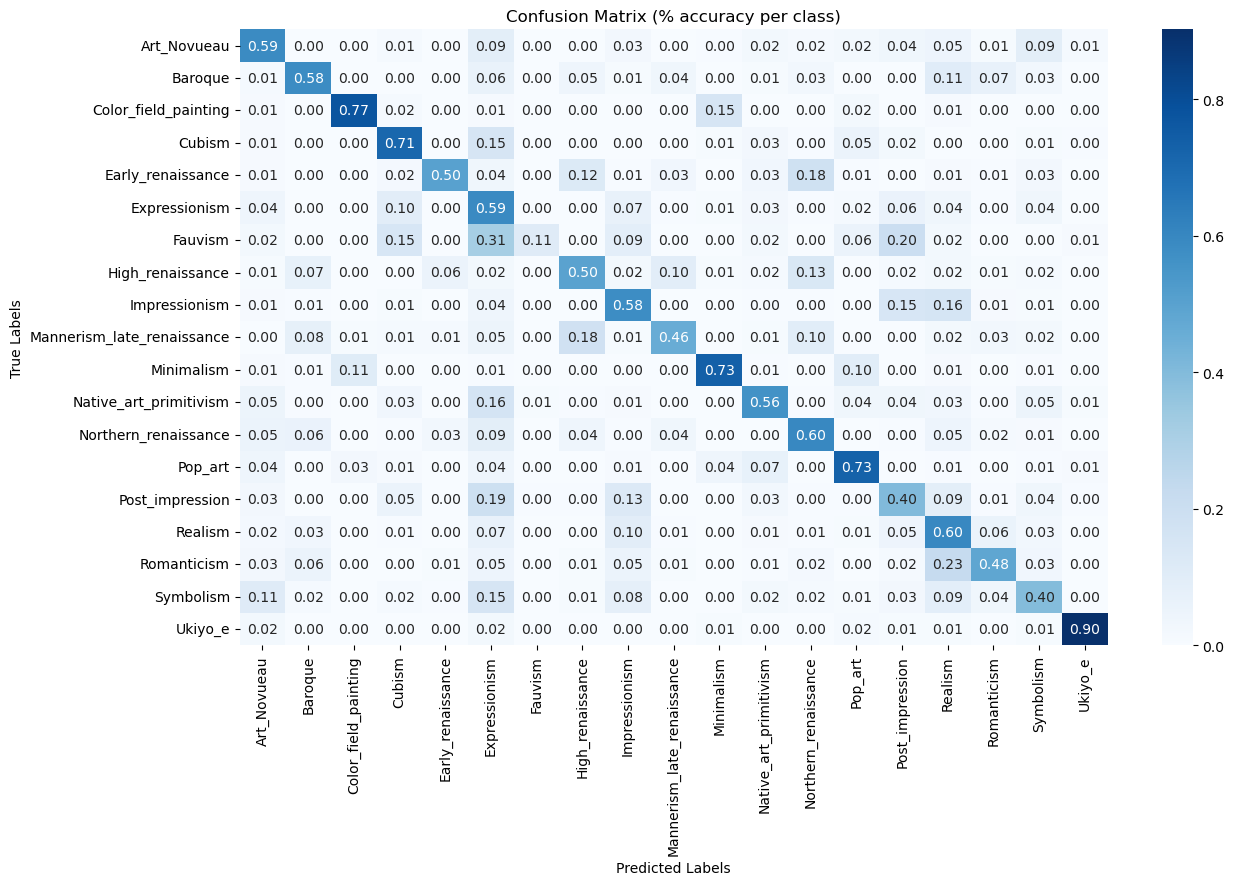

                            precision    recall  f1-score   support

               Art_Novueau       0.54      0.59      0.56       413
                   Baroque       0.65      0.58      0.62       418
      Color_field_painting       0.85      0.77      0.81       182
                    Cubism       0.53      0.71      0.61       261
         Early_renaissance       0.75      0.50      0.60       157
             Expressionism       0.40      0.59      0.47       659
                   Fauvism       0.59      0.11      0.19        89
          High_renaissance       0.39      0.50      0.44       126
             Impressionism       0.69      0.58      0.63      1314
Mannerism_late_renaissance       0.51      0.46      0.48       137
                Minimalism       0.70      0.73      0.72       147
    Native_art_primitivism       0.58      0.56      0.57       278
      Northern_renaissance       0.54      0.60      0.57       240
                   Pop_art       0.54      0.73

In [9]:
# Path to saved model
model_path = 'C:\\Users\\PRANAV\\Downloads\\Model2_c.h5'
model = load_model(model_path)


test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 224
image_width = 224

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))